# Lab 9: Convolutional neural nets
In this lab we consider the [CIFAR dataset](https://www.openml.org/d/40926), but model it using convolutional neural networks instead of linear models.

Tip: You can run these exercises faster on a GPU (but they will also run fine on a CPU). If work on colab, you can enable GPU support at “runtime” -> “change runtime type”.

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.14.2-py3-none-any.whl size=158699 sha256=d4cfa3f5eb65ef09875f10225256392f681fc139948893913961f0e67f26b397
  Stored in directory: /root/.cache/pip/wheels/2e/4e/af/5e721761d86375dbca82e63cc2470019e97815bc39f11451ea
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=1aa184e9b12cbc8b984817e0617254610e8fe38c716e62650872a42d6630769a
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built

In [2]:
# Uncomment the next line if you run on Colab
!pip install --quiet openml

In [ ]:
%matplotlib inline
import openml as oml
import matplotlib.pyplot as plt

In [3]:
# Download CIFAR data. Takes a while the first time.
# This version returns 3x32x32 resolution images.
cifar = oml.datasets.get_dataset(40926)
X, y, _, _ = cifar.get_data(target=cifar.default_target_attribute, dataset_format='array');
cifar_classes = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
                 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

<ipython-input-3-1b9af295301c>:3: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  cifar = oml.datasets.get_dataset(40926)
<ipython-input-3-1b9af295301c>:4: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = cifar.get_data(target=cifar.default_target_attribute, dataset_format='array');


In [4]:
# The dataset (40926) is in a weird 3x32x32 format, we need to reshape and transpose
Xr = X.reshape((len(X),3,32,32)).transpose(0,2,3,1)

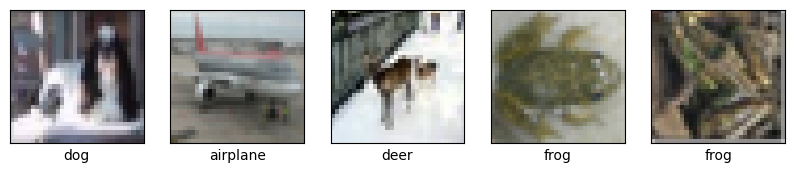

In [5]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,len(Xr))
    # The data is stored in a 3x32x32 format, so we need to transpose it
    axes[i].imshow(Xr[n]/255)
    axes[i].set_xlabel((cifar_classes[int(y[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

## Exercise 1: A simple model
* Split the data into 80% training and 20% validation sets
* Normalize the data to [0,1]
* Build a ConvNet with 3 convolutional layers interspersed with MaxPooling layers, and one dense layer.
    * Use at least 32 3x3 filters in the first layer and ReLU activation.
    * Otherwise, make rational design choices or experiment a bit to see what works.
* You should at least get 60% accuracy.
* For training, you can try batch sizes of 64, and 20-50 epochs, but feel free to explore this as well
* Plot and interpret the learning curves. Is the model overfitting? How could you improve it further?

In [9]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(Xr, y, train_size=0.8, stratify=y)

# Normalize data into 0,1
X_train_normalized = X_train.astype('float32') / 255
X_test_normalized  = X_test.astype('float32') / 255
y_train_encoded    = tf.keras.utils.to_categorical(y_train)
y_test_encoded     = tf.keras.utils.to_categorical(y_test)

In [ ]:
def build_cnn(output_layer_units=10):
  model = Sequential(name="CIFAR_CNN_MODEL")

  # Convolutional
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))

  # Dense
  model.add(layers.Flatten())
  model.add(layers.Dense(output_layer_units, activation='softmax'))

  # Compile
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
def train_model(model, X, y, validation_split=0.1, epochs=10, batch_size=None, verbose=True):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, stratify=y)

    # Callback
    stop_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        verbose=0,
    )

    # Build model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[stop_callback])
    if not verbose:
      print(f"validation_accuracy = {np.max(history.history['val_accuracy'])}")
    return history

In [ ]:
# Helper plotting function
def plot_curve(history, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m, lw=2)
    plt.legend()

In [ ]:
# Build the model
model = build_cnn()

# Let's train the model
history = train_model(model, X_train_normalized, y_train_encoded, validation_split=0.2, epochs=32, batch_size=64)

Model: "CIFAR_CNN_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)          


TEST_SET(LOSS=1.3090375661849976 and ACCURACY=0.6392499804496765)



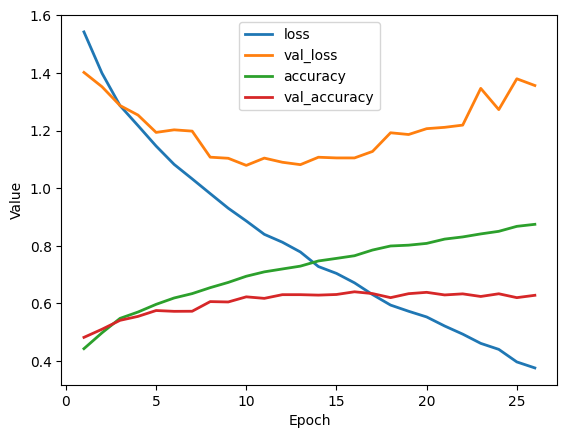

In [ ]:
# Plot performance
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Let's report the performance on test set
test_score = model.evaluate(
    x=X_test_normalized,
    y=y_test_encoded,
    batch_size=4000,
    verbose=False,
    return_dict=True
)
print(f"\nTEST_SET(LOSS={test_score['loss']} and ACCURACY={test_score['accuracy']})\n")

**Interpretation**
> - Is the model overfitting? How could you improve it further?<br>
We can observe that as epoch increase the validation_loss in hight than training loss. Therefore the model is overfitting.

## Exercise 2: VGG-like model
* Implement a simplified VGG model by building 3 'blocks' of 2 convolutional layers each
* Do MaxPooling after each block
* The first block should use at least 32 filters, later blocks should use more
* You can use 3x3 filters
* Use zero-padding to be able to build a deeper model (see the `padding` attribute)
* Use a dense layer with at least 128 hidden nodes.
* You can use ReLU activations everywhere (where it makes sense)
* Plot and interpret the learning curves

In [ ]:
def build_vgg_cnn(output_layer_units=10):
  model = Sequential(name="CIFAR_VGG_LIKE_CNN_MODEL")

  # Block 1
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Block 2
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Block 3
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  # Dense
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(output_layer_units, activation='softmax'))

  # Compile
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
# Build the model
model2 = build_vgg_cnn()

# Let's train the model
history2 = train_model(model2, X_train_normalized, y_train_encoded, validation_split=0.2, epochs=32, batch_size=64)

Model: "CIFAR_VGG_LIKE_CNN_MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                     


TEST_SET(LOSS=1.3090375661849976 and ACCURACY=0.6392499804496765)



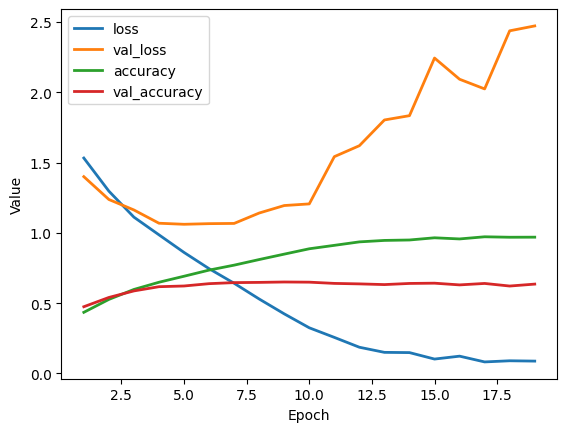

In [ ]:
# Plot performance
plot_curve(history2, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Let's report the performance on test set
test_score = model.evaluate(
    x=X_test_normalized,
    y=y_test_encoded,
    batch_size=4000,
    verbose=False,
    return_dict=True
)
print(f"\nTEST_SET(LOSS={test_score['loss']} and ACCURACY={test_score['accuracy']})\n")

## Exercise 3: Regularization
* Explore different ways to regularize your VGG-like model
  * Try adding some dropout after every MaxPooling and Dense layer.
    * What are good Dropout rates? Try a fixed Dropout rate, or increase the rates in the deeper layers.
  * Try batch normalization together with Dropout
    * Think about where batch normalization would make sense
* Plot and interpret the learning curves


In [ ]:
# MODEL WITH DROPOUT WITH FIXED VALUES
def model_reg1(output_layer_units=10):
  model = Sequential()
  # Block 1
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  # Block 2
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  # Block 3
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  # Dense
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(output_layer_units, activation='softmax'))
  # Compile
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# Build the model
model   = model_reg1()
history = train_model(model, X_train_normalized, y_train_encoded, validation_split=0.2, epochs=32, batch_size=64, verbose=False)

# Plot performance
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

**Notes:**<br>
> On voit que l'ajout de couche "Dropout" reduit énormement l'overfitting. Essayons maintenant d'utiliser un coeficcient  croissant pour le Dropout.

In [ ]:
# MODEL WITH DROPOUT WITH NON-FIXED VALUES
def model_reg2(output_layer_units=10):
  model = Sequential()
  # Block 1
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  # Block 2
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  # Block 3
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.5))
  # Dense
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.6))
  model.add(layers.Dense(output_layer_units, activation='softmax'))
  # Compile
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# Build the model
model   = model_reg2()
history = train_model(model, X_train_normalized, y_train_encoded, validation_split=0.2, epochs=32, batch_size=64, verbose=False)

# Plot performance
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

**Notes:**<br>
> On voit que l'ajout de couche "Dropout" avec un coefficient croissant reduit plus l'overfitting mais on perd legerement en performance de prediction quand a notre score de validation

> BatchNormalization is typically used in deep learning models after the linear transformation (such as a fully connected layer or convolutional layer) and before the non-linear activation function. It is used to normalize the activations of the previous layer at each batch during training.

In [ ]:
# MODEL WITH BATCH_NORMALIZATION
def model_reg3(output_layer_units=10):
  model = Sequential()
  # Block 1
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  # Block 2
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  # Block 3
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.5))
  # Dense
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.6))
  model.add(layers.Dense(output_layer_units, activation='softmax'))
  # Compile
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# Build the model
model_reg3   = model_reg3()
history = train_model(model_reg3, X_train_normalized, y_train_encoded, validation_split=0.2, epochs=32, batch_size=64, verbose=False)

# Plot performance
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

**Notes:**<br>
> On voit que la normalization a pour consequence d'augùenter notre precision tout en garantissant que le model n'overfit pas.

## Exercise 4: Data Augmentation
* Perform image augmentation (rotation, shift, shear, zoom, flip,...). You can use the ImageDataGenerator for this.
* What is the effect? What is the effect with and without Dropout?
* Plot and interpret the learning curves


In [7]:
# DATA AUGMENTATION
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range=0.0,
    zoom_range=2.0,
    horizontal_flip=True,
    #vertical_flip=True
)

In [ ]:
# MODEL WITH BATCH_NORMALIZATION
def model_reg4(output_layer_units=10):
  model = Sequential()
  # Block 1
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  # Block 2
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  # Block 3
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.5))
  # Dense
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.6))
  model.add(layers.Dense(output_layer_units, activation='softmax'))
  # Compile
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# Callback
stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose=0,
)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_train_normalized, y_train_encoded, test_size=0.2, stratify=y_train_encoded)
datagen.fit(X_train)

# Build the model
model   = model_reg4()
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train)//32, epochs=32, validation_data=(X_val, y_val), verbose=True, callbacks=[stop_callback])
print(f"validation_accuracy = {np.max(history.history['val_accuracy'])}")

# Plot performance
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

Epoch 1/32
400/400 [==============================] - 120s 294ms/step - loss: 2.7882 - accuracy: 0.1713 - val_loss: 2.4861 - val_accuracy: 0.1531
Epoch 2/32
400/400 [==============================] - 112s 280ms/step - loss: 2.2296 - accuracy: 0.2151 - val_loss: 1.9663 - val_accuracy: 0.2897
Epoch 3/32
400/400 [==============================] - 120s 300ms/step - loss: 2.0593 - accuracy: 0.2487 - val_loss: 1.8737 - val_accuracy: 0.3241
Epoch 4/32
400/400 [==============================] - 114s 286ms/step - loss: 1.9848 - accuracy: 0.2717 - val_loss: 1.9448 - val_accuracy: 0.3034
Epoch 5/32
400/400 [==============================] - 129s 322ms/step - loss: 1.9430 - accuracy: 0.2871 - val_loss: 1.7772 - val_accuracy: 0.3503
Epoch 6/32
400/400 [==============================] - 115s 287ms/step - loss: 1.9137 - accuracy: 0.3027 - val_loss: 1.6591 - val_accuracy: 0.4119
Epoch 7/32
400/400 [==============================] - 109s 271ms/step - loss: 1.8907 - accuracy: 0.3107 - val_loss: 1.6700 -

NameError: name 'plot_curve' is not defined

**Notes:**<br>
> ...
><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
>
>
>
>...

## Exercise 5: Interpret the misclassifications
Chances are that even your best model is not yet perfect. It is important to understand what kind of errors it still makes.
* Run the test images through the network and detect all misclassified ones
* Interpret some of the misclassifications. Are these misclassifications to be expected?
* Compute the confusion matrix. Which classes are often confused?

In [ ]:
# LET'S USE OUR BEST MODEL
best_model = model_reg3

In [ ]:
# LET'S VISUALIZE SOME MISCLASSIFIED IMAGES
y_pred   = best_model.predict(X_test)
bad_pred = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]

fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for nr, i in enumerate(bad_pred[:5]):
    axes[nr].imshow(X_test[i])
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (cifar_classes[np.argmax(y_pred[i])],cifar_classes[np.argmax(y_test[i])]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())
plt.show();

**Notes:**<br>
> ...

In [ ]:
# LET'S PLOT CONFUSION MATRIX
cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(cifar_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(cifar_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

**Notes:**<br>
> ...

## Exercise 6: Interpret the model
Retrain your best model on all the data. Next, retrieve and visualize the activations (feature maps) for every filter for every convolutional layer, or at least for a few filters for every layer. Tip: see the course notebooks for examples on how to do this.

Interpret the results. Is your model indeed learning something useful?

In [ ]:
# LET'S USE OUR BEST MODEL
best_model = model_reg3

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import models

def visualize_activations(model, layer_number, image_position, X_test):
    # Extracting the output of the chosen layer
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(X_test[image_position].reshape(1, 28, 28, 1))

    # Getting the names of the layers
    layer_names = [layer.name for layer in model.layers]

    # Retrieving the activations of the specified layer
    layer_activation = activations[layer_number]

    # Plotting the original image
    plt.figure(figsize=(8, 8))
    plt.subplot(1, len(layer_activation) + 1, 1)
    plt.imshow(X_test[image_position].reshape(28, 28), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plotting the activations of each filter in the specified layer
    for i in range(len(layer_activation)):
        plt.subplot(1, len(layer_activation) + 1, i + 2)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.title(f'Layer {layer_number} - Filter {i}')
        plt.axis('off')

    plt.show()

# Example usage
model = ...  # Your trained CNN model
layer_number = 1  # Layer number to visualize
image_position = 0  # Image position in X_test
X_test = ...  # Your test data

visualize_activations(model, layer_number, image_position, X_test)

In [ ]:
# LET'S USE OUR BEST MODEL
best_model = model

# LET'S GET A LOOK OF THE ACTIVATION FOR EACH MAPS
from tensorflow.keras import models

img_tensor = X_test[4]
img_tensor = np.expand_dims(img_tensor, axis=0)

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:15]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)



first_layer_activation = activations[0]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(img_tensor[0])
ax2.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Input image')
ax2.set_xlabel('Activation of filter 2');

## Exercice 7: Take it a step further
* Repeat the exercises, but now use a [higher-resolution version of the CIFAR dataset](https://www.openml.org/d/40926) (with OpenML ID 41103).
